In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from minisom import MiniSom
from keras.models import Sequential
from keras.layers import LSTM, Dense
from pykalman import KalmanFilter
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
Katleho = pd.read_csv('btc.csv')
Katleho['Date'] = pd.to_datetime(Katleho['Date'], format='%Y-%m-%d')
Hlompho = Katleho.set_index(['Date'])
Hlompho = Hlompho.asfreq('B')
print(Hlompho)

                     Open           High           Low         Close  \
Date                                                                   
2014-09-17     465.864014     468.174011    452.421997    457.334015   
2014-09-18     456.859985     456.859985    413.104004    424.440002   
2014-09-19     424.102997     427.834991    384.532013    394.795990   
2014-09-22     399.100006     406.915985    397.130005    402.152008   
2014-09-23     402.092010     441.557007    396.196991    435.790985   
...                   ...            ...           ...           ...   
2024-12-04   95988.531250   99207.328125  94660.523438  98768.531250   
2024-12-05   98741.539062  103900.468750  91998.781250  96593.570312   
2024-12-06   97074.226562  102039.882812  96514.875000  99920.710938   
2024-12-09  101237.062500  101272.507812  94355.914062  97432.718750   
2024-12-10   97441.234375   98270.156250  94321.257812  96675.429688   

               Adj Close        Volume  
Date                  

In [5]:
# Step 1: Create Log_Close and Drop NaNs
Hlompho['Log_Close'] = np.log(Hlompho['Close'])
Hlompho.dropna(subset=['Log_Close'], inplace=True)

c:\Users\katle\anaconda3\envs\Makatjane\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


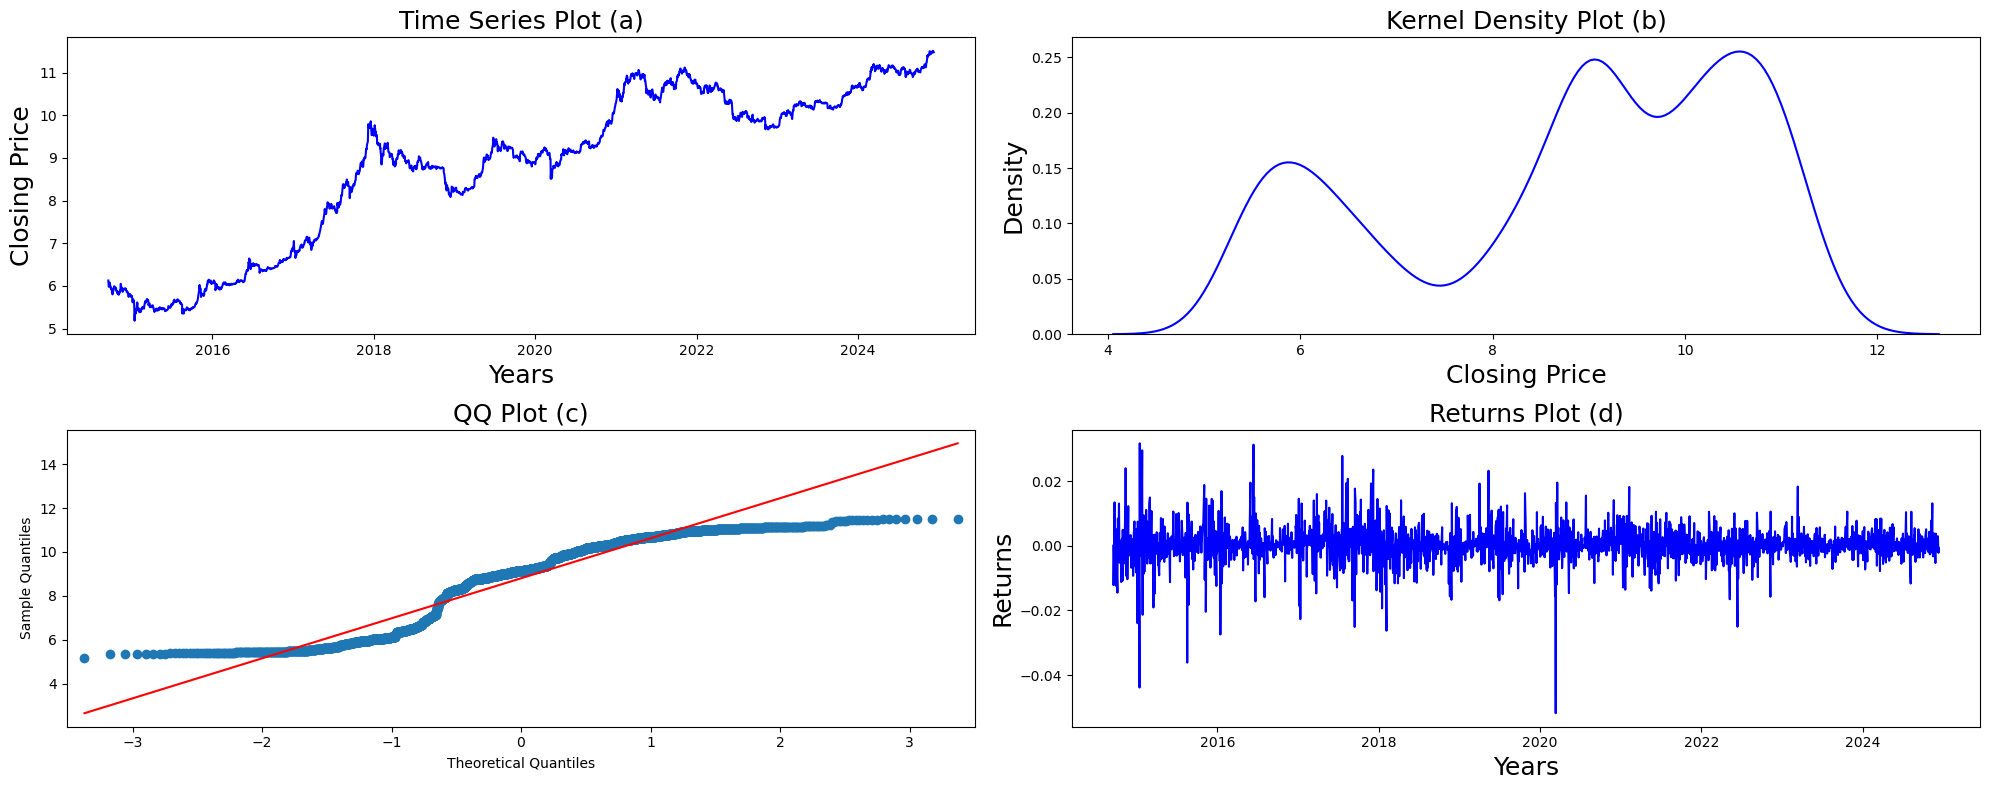

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
# Time Series Plot
axes[0, 0].plot(Hlompho.index, Hlompho['Log_Close'],color='blue')
axes[0, 0].set_title('Time Series Plot (a)', fontsize=18)
axes[0, 0].set_xlabel('Years', fontsize=18)
axes[0, 0].set_ylabel('Closing Price', fontsize=18)
axes[0, 0].grid(False)
# Kernel Density Plot
sns.kdeplot(Hlompho['Log_Close'], ax=axes[0, 1],color='blue')
axes[0, 1].set_title('Kernel Density Plot (b)', fontsize=18)
axes[0, 1].set_xlabel('Closing Price', fontsize=18)
axes[0, 1].set_ylabel('Density', fontsize=18)
axes[0, 1].grid(False)
# QQ Plot
sm.qqplot(Hlompho['Log_Close'], line='s', ax=axes[1, 0], color='red')
axes[1, 0].set_title('QQ Plot (c)', fontsize=18)
axes[1, 0].grid(False)
# Returns Plot
Hlompho['Returns'] = Hlompho['Log_Close'].pct_change().fillna(0)
axes[1, 1].plot(Hlompho.index, Hlompho['Returns'],color='blue')
axes[1, 1].set_title('Returns Plot (d)', fontsize=18)
axes[1, 1].set_xlabel('Years', fontsize=18)
axes[1, 1].set_ylabel('Returns', fontsize=18)
axes[1, 1].grid(False)
plt.tight_layout()
plt.show()

In [8]:
# Step 2: Normalize Log_Close
scaler = MinMaxScaler()
log_close_scaled = scaler.fit_transform(Hlompho[['Log_Close']])
# Step 3: Apply Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
state_means, _ = kf.em(log_close_scaled).filter(log_close_scaled)

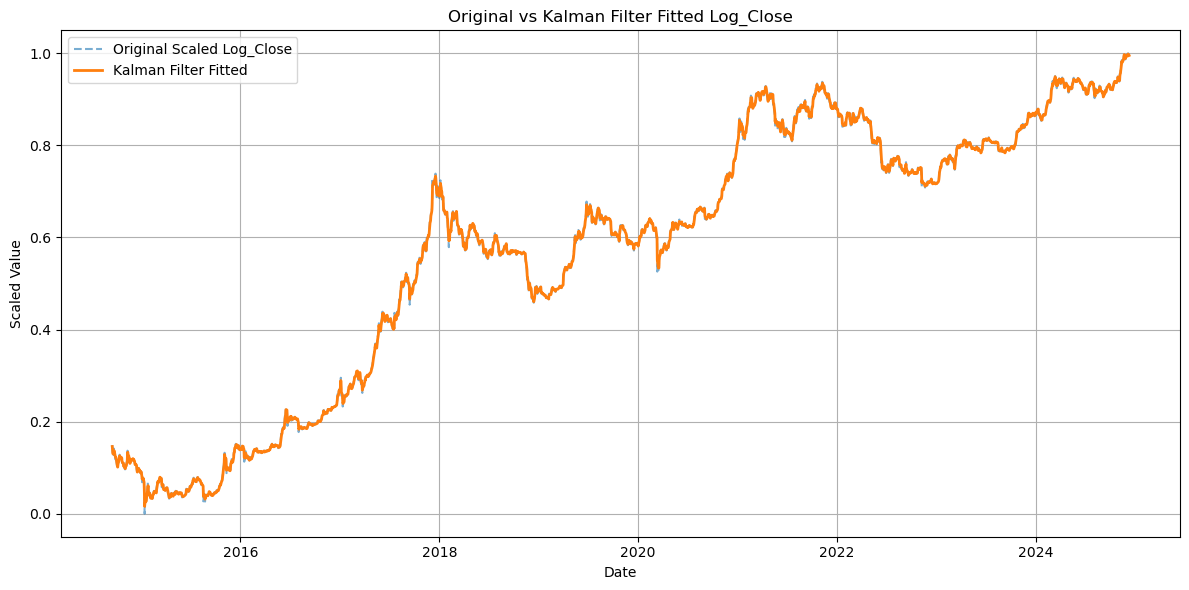

In [9]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(Hlompho.index, log_close_scaled, label='Original Scaled Log_Close', linestyle='--', alpha=0.6)
plt.plot(Hlompho.index, state_means, label='Kalman Filter Fitted', linewidth=2)
plt.title('Original vs Kalman Filter Fitted Log_Close')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Step 4: Create Sequences for LSTM
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

seq_len = 24  # Example: 24-hour window
X_lstm, y_lstm = create_sequences(state_means, seq_len)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

# Step 5: LSTM Model
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_len, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_lstm, y_lstm, epochs=200, batch_size=32, verbose=1)

Epoch 1/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1511
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5522e-04
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6046e-04
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4548e-04
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3187e-04
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2177e-04
Epoch 8/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1658e-04
Epoch 9/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9148e-04
Epoch 10/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0397e-04
Epoch 11/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8690e-04
Epoch 12/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1320e-04
Epoch 13/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7604e-04
Epoch 14/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7776e-04
Epoch 15/200
83/83 ━

In [13]:
# Step 6: SOM for Clustering Patterns
data_for_som = state_means.reshape(-1, 1)
som = MiniSom(x=3, y=3, input_len=1, sigma=1.0, learning_rate=0.5)
som.train_random(data_for_som, 100)

# Assign clusters based on SOM
winner_coordinates = np.array([som.winner(x) for x in data_for_som])
cluster_index = np.ravel_multi_index(winner_coordinates.T, (3, 3))

# Step 7: CNE (Ensemble per Cluster)
predictions = []
actuals = []

for cluster in np.unique(cluster_index):
    idx = np.where(cluster_index[seq_len:] == cluster)[0]  # Adjust index due to sequence shift
    if len(idx) == 0:
        continue
    X_cluster = X_lstm[idx]
    y_cluster = y_lstm[idx]

In [15]:
   # Train ensemble regressor (e.g., Gradient Boosting)
ensemble_model = GradientBoostingRegressor()
ensemble_model.fit(X_cluster.reshape(X_cluster.shape[0], -1), y_cluster)

    # Predict
preds = ensemble_model.predict(X_cluster.reshape(X_cluster.shape[0], -1))
predictions.extend(preds)
actuals.extend(y_cluster)


c:\Users\katle\anaconda3\envs\Makatjane\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Mean Squared Error (CNE output): 0.0000


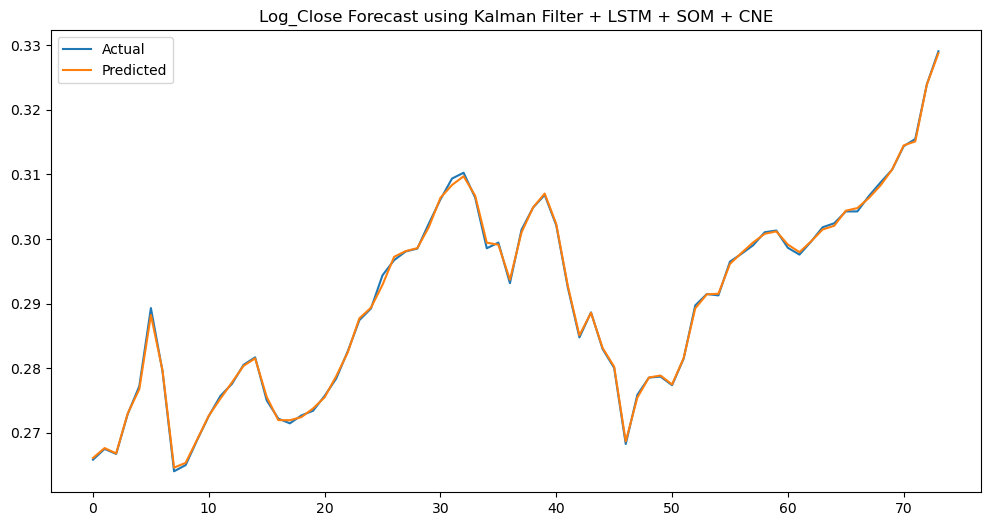

In [16]:
mse = mean_squared_error(actuals, predictions)
print(f"Mean Squared Error (CNE output): {mse:.4f}")

# Step 9: Plot
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Log_Close Forecast using Kalman Filter + LSTM + SOM + CNE')
plt.legend()
plt.show()